**План**:

- смотрим пропуски - их нет
- смотрим аутлаеров - один
- убиваем аутлаеров - убит
- нормализуем данные - +таргет
- чекаем модель - не лучше базы
- чистим через лассо
- пробуем лин рег - не оч
- пробуем мудрые регуляризации
- пробуем так чисто бустинг - супер добро
- пробуем кластеризовать - добро

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

pd.set_option("display.max_columns", None)

train = pd.read_csv("train.csv")
formula_train = pd.read_csv("formula_train.csv")

print(f"Train dataset shape: {train.shape}")
print(f"Train_formula dataset shape: {formula_train.shape}")

test = pd.read_csv("test.csv")
formula_test = pd.read_csv("formula_test.csv")

print(f"Test dataset shape: {test.shape}")
print(f"Test_formula dataset shape: {formula_test.shape}")

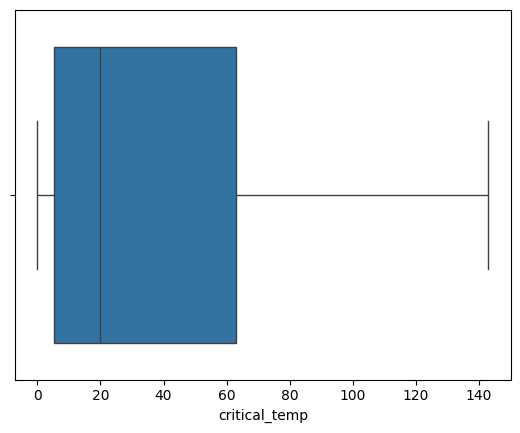

In [427]:
sns.boxplot(data=train, x="critical_temp")
plt.show()

In [352]:
th = 150
train[train["critical_temp"] > th].shape

(1, 82)

In [353]:
# убиваем
train = train[train["critical_temp"] <= th]
formula_train = formula_train[formula_train["critical_temp"] <= th]

In [354]:
full_train = pd.concat([train, formula_train.drop(columns=["critical_temp", "material"])], axis=1)
full_test = pd.concat([test, formula_test.drop(columns=["material"])], axis=1)

In [417]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(full_train.drop(columns=['critical_temp']))
y = y_scaler.fit_transform(full_train['critical_temp'].values.reshape(-1, 1))
X_test = x_scaler.transform(full_test)

In [418]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)

In [357]:
def test_model(model, x, y):
    y_pred = model.predict(x).reshape(-1, 1)
    y_pred = y_scaler.inverse_transform(y_pred)
    y_true = y_scaler.inverse_transform(y)
    print("without guard:")
    print(f"R^2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print("with guard:")
    y_pred = np.where(y_pred < 0.0, 0.0, y_pred)
    print(f"R^2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    
def save_solution(model, filename="solution.csv", guard=False):
    y_pred = y_scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
    if guard:
        y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = pd.DataFrame(y_pred, columns=['critical_temp'])
    y_pred = y_pred.reset_index()

    y_pred.to_csv(filename, index=False)

In [419]:
model = LinearRegression().fit(X_train, y_train)
test_model(model, X_val, y_val) # not so good

without guard:
R^2: 0.7710365978897646
MSE: 264.2949323800803
with guard:
R^2: 0.7781647430624277
MSE: 256.0668372826056


In [161]:
save_solution(model, "solution1.csv", True)

### Lasso takes part

In [420]:
model = Lasso(alpha=0.01).fit(X_train, y_train)
test_model(model, X_val, y_val)

without guard:
R^2: 0.7343287751547467
MSE: 306.66716933217026
with guard:
R^2: 0.7377198890242507
MSE: 302.75276990163513


In [375]:
len(model.coef_)

167

In [376]:
(np.abs(model.coef_) < 1e-12).sum()

np.int64(111)

In [377]:
small = (np.abs(model.coef_) < 1e-12)
X_train = X_train[:, ~small]
X_val = X_val[:, ~small]
X_test = X_test[:, ~small]
X_train.shape, X_test.shape

((13607, 56), (4253, 56))

In [378]:
model = LinearRegression().fit(X_train, y_train)
test_model(model, X_val, y_val)

without guard:
R^2: 0.7428858590863874
MSE: 296.7896347644632
with guard:
R^2: 0.7486935884283067
MSE: 290.08570994697055


In [166]:
save_solution(model, "drop_with_lasso.csv", True)

**ВСЁ ПЛОХО**

### GBDT

In [212]:
y_train.shape

(13607, 1)

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train.ravel())
test_model(model)
print("with guard: ")
test_model(model, X_val, y_val)

R^2: 0.8810668733238813
MSE: 137.28579494762477
with guard: 
R^2: 0.8810749320876253
MSE: 137.27649262944132


In [219]:
save_solution(model, "gbdt_no_outliers.csv", True)

### Clustering first

In [409]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
import sklearn
from sklearn.base import clone

In [423]:
class ClusterModel(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, clusterizer, base_model):
        self.clusterizer = clusterizer
        self.base_model = base_model
        self.models = []
    
    def fit(self, X, y):
        if hasattr(self.clusterizer, "predict"):
            self.clusterizer.fit(X)
            labels = self.clusterizer.predict(X)
        else:
            clustering = self.clusterizer.fit(X)
            labels = clustering.labels_
        for i in range(self.clusterizer.n_clusters):
            model = clone(self.base_model)
            model.fit(X[labels == i], y[labels == i].ravel())
            self.models.append(model)
        
    def predict(self, X):
        if hasattr(self.clusterizer, "predict"):
            labels = self.clusterizer.predict(X)
        else:
            clustering = self.clusterizer.fit(X)
            labels = clustering.labels_
        y = np.zeros(X.shape[0])
        for i in set(labels):
            y[labels == i] = self.models[i].predict(X[labels == i]).ravel()
        return y.reshape(-1, 1)

In [424]:
model = ClusterModel(KMeans(n_clusters=3), LinearRegression())
model.fit(X_train, y_train)
test_model(model, X_val, y_val)

without guard:
R^2: 0.8397852426650778
MSE: 184.93762787354805
with guard:
R^2: 0.8425567007069352
MSE: 181.73850386937954


In [349]:
save_solution(model, "solution.csv", guard=True)

In [416]:
model = ClusterModel(AgglomerativeClustering(n_clusters=2), LinearRegression())
model.fit(X_train, y_train)
test_model(model, X_val, y_val)

without guard:
R^2: -1.7639365254191857
MSE: 3190.441836362994
with guard:
R^2: -0.7568667005306049
MSE: 2027.9702412615143


In [430]:
model = ClusterModel(KMeans(n_clusters=3), GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3))
model.fit(X_train, y_train)
test_model(model, X_val, y_val)

without guard:
R^2: 0.9023038493294724
MSE: 112.77172376583486
with guard:
R^2: 0.9023041615829103
MSE: 112.77136332831302


In [429]:
save_solution(model, "solution.csv", guard=True)